In [27]:
import numpy as np
from skfem import *
from skfem.models.elasticity import linear_elasticity, lame_parameters
from skfem.models.ani_elasticity import *
from skfem.visuals.matplotlib import plot, draw
from skfem.helpers import dot, sym_grad, jump, mul


input: -Gitter des 3D objekts im Mesh Format (Hürden: Wie bekomme ich die äußersten Netzpunkte von allen Seiten in Subdomains?)
      -Material des Objektes: Zu jedem Material sollen dann Elastic Modulus gegeben sein. 
      - Stärke der Kraft definieren
      - FEA von allen 6 Seiten. 
      - Ausgabe der K Matrix ob Verschiebung plastisch ist folglich Kaputt, oder nicht 

Verschiebungen der oberen Knoten:
[0.06367946 0.06367946 0.06367946 0.06367946 0.04076993 0.04076993
 0.04076993 0.04076993 0.03066494 0.04233234 0.04233234 0.04233234
 0.04233234 0.04233234 0.04233234 0.04233234 0.04233234 0.03173022
 0.03173022 0.03173022 0.03173022 0.03357722 0.03357722 0.03357722
 0.03357722]
225


<Axes3D: >

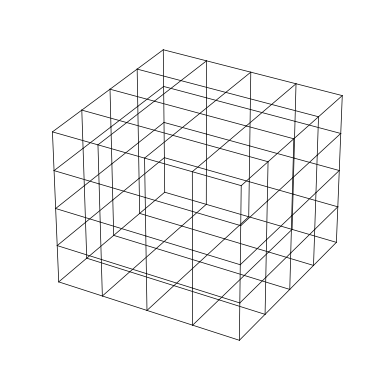

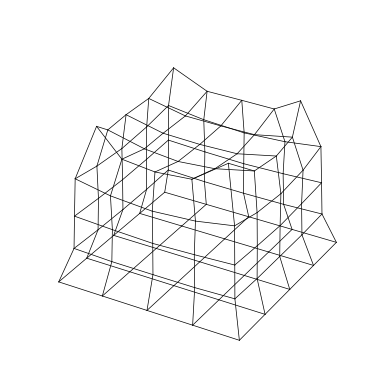

In [32]:


m = MeshHex().refined(2)
e1 = ElementHex1()

draw(m)  
e = ElementVector(e1)

ib = Basis(m, e, MappingIsoparametric(m, e1), 3) #MappingIsoparametric legt die Punkte + Element von Global auf Lokale Koordinaten zur Integrateion 

young_modulus = 31.1e9
nu = 0.35
K = asm(linear_elasticity(*lame_parameters(young_modulus,nu)), ib) #Füge die DGL und die Materialkonstanten zusammen und legt Sie auf die Basis fest
                                                            # young Modulus E = sigma/Epsilon Verhältnis zwischen Spannung und innerer Verzerrung im Material 
                                                            # poisson ratio: nu = d_x/dy Verhältnis wie weit das Material gestreckt/gestaucht wird, wenn eine Kraft auf zwei gegenseitige Seiten wirkt.


dofs = {
    'left' : ib.get_dofs(lambda x: x[0] == 0.0),        # wir legen die DOFS fest ganz genau an den Punkten, wo wir wissen, dass die linke und rechte
    'right': ib.get_dofs(lambda x: x[0] == 1.0),
    'up': ib.get_dofs(lambda x: x[2] == 1.0),              # Kante liegt. Wie kann ich das auf ein beliebiges Netz übertragen?
    'down': ib.get_dofs(lambda x: x[2] == 0.0),             # Kante liegt. Wie kann ich das auf ein beliebiges Netz übertragen?
    'front': ib.get_dofs(lambda x: x[1] == 0.0),             # Kante liegt. Wie kann ich das auf ein beliebiges Netz übertragen?
    'back': ib.get_dofs(lambda x: x[1] == 1.0)             # Kante liegt. Wie kann ich das auf ein beliebiges Netz übertragen?
}                                           

u = ib.zeros()     # erstellen einer Matrix der Form ib bestehend aus Nullen 

#############################
Kraft = 50000000  # 500N pro Knoten
F = np.zeros(u.shape)
up_dofs = dofs['up'].nodal['u^3']  # Nur die Z-Komponente der oberen Knoten
F[up_dofs] = Kraft

# Randbedingungen festlegen (z.B. Verschiebung an 'left' fixieren)
fixed_dofs = np.hstack([dofs['down'].all()])
u[fixed_dofs] = 0

# Randbedingungen in die Steifigkeitsmatrix integrieren
free_dofs = np.setdiff1d(np.arange(K.shape[0]), fixed_dofs)
K_free = K[free_dofs][:, free_dofs]
F_free = F[free_dofs]

# Verschiebungen lösen
u_free = solve(K_free, F_free)
u[free_dofs] = u_free

# Verschiebungen der oberen Knoten
verschiebung_oben = u[up_dofs]

print("Verschiebungen der oberen Knoten:")
print(verschiebung_oben)
################################
u[[dofs['up'].nodal['u^3']]]  = verschiebung_oben                   # setzen der Anfangswerte für die Anfangsbedigungen ['u^1, u^2,u^3] gibt die Richtung der einzlenen auslenkungen an 
                                                        #sind das Kraft WERTE oder AUSLENKUNGSWERTE?

I = ib.complement_dofs(np.concatenate((dofs['up'], dofs['down'])))            # festlegen der Randbedingungnen, die Festgehalten werden sollen, also Knoten ohne DOFs
print(len(I))
                                                                
                                                                    #     AThe system matrix
                                                                    # b
                                                                    #     The right hand side vector, or zero if x is given, or the mass matrix
                                                                    #     for generalized eigenvalue problems.
                                                                    # x
                                                                    #     The values of the condensed degrees-of-freedom. If not given, assumed
                                                                    #     to be zero.
                                                                    # I
                                                                    #     The set of degree-of-freedom indices to include.
                                                                    # D
                                                                    #     The set of degree-of-freedom indices to dismiss.
u = solve(*condense(K, x=u, I=I))                       # er unterteilt die ib matrix in bekannte und unbekannte Kräfte und löst dann nach einandern 
                                                        # I = I beschreibt dass wir nach unbekannten auflösen D=D beschreibt nach bekannten aufzulösen 
                                                        

factor = 10                                # Übertreibungsfaktor 

m = m.translated( factor * u[ib.nodal_dofs])             # translate verschiebt um den Faktor Vektor
                                    #gibt alle Dofs einer base an 

draw(m)                                               # Was heißt .noadl['u^1]
                                             # Was heißt .noadl['u^1]
                                               # Was heißt .noadl['u^1]

In [6]:
m = MeshHex().refined(4)
e1 = ElementHex1()

 
e = ElementVector(e1)

ib = Basis(m, e, MappingIsoparametric(m, e1), 3) 

young_modulus = 31.1e9
nu = 0.35
#K = asm(linear_elasticity_anisotropic(*lame_parameters(young_modulus,nu)), ib)

@BilinearForm
def weakform(u, v, w):
    mu = 10 * (w.x[2] < 0.5) + 100 * (w.x[2] >= 0.5)
    lmbda = 10 * (w.x[2] < 0.5) + 20 * (w.x[2] >= 0.5)
    epsu = sym_grad(u)
    Cepsu = 2. * mu * epsu + lmbda * eye(trace(epsu), epsu.shape[0])
    return ddot(Cepsu, sym_grad(v))


K = asm(weakform(*lame_parameters(young_modulus, nu)), ib )



Named boundaries invalidated by a call to Mesh.refined()


AttributeError: 'BilinearForm' object has no attribute 'kernel'

TEST OF VAN MISES WITH FORCE APPLICATION 

Verschiebungen der oberen Knoten:
[0.06367946 0.06367946 0.06367946 0.06367946 0.04076993 0.04076993
 0.04076993 0.04076993 0.03066494 0.04233234 0.04233234 0.04233234
 0.04233234 0.04233234 0.04233234 0.04233234 0.04233234 0.03173022
 0.03173022 0.03173022 0.03173022 0.03357722 0.03357722 0.03357722
 0.03357722]


ValueError: 'c' argument has 768 elements, which is inconsistent with 'x' and 'y' with size 125.

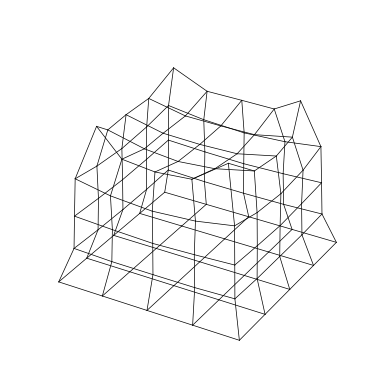

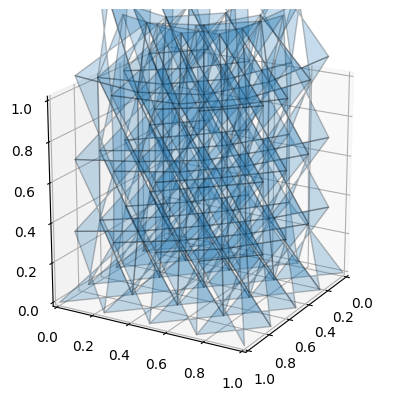

In [18]:
import numpy as np
from skfem import *
from skfem.models.elasticity import (linear_elasticity, lame_parameters, linear_stress)
from skfem.helpers import dot, sym_grad
from skfem.visuals.matplotlib import draw
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Initialisieren des Netzes und der Elemente
m = MeshHex().refined(2)
e1 = ElementHex1()
e = ElementVector(e1)
ib = Basis(m, e, MappingIsoparametric(m, e1), 3)

# Materialparameter
young_modulus = 31.1e9
nu = 0.35

# Assemblierung der Steifigkeitsmatrix
K = asm(linear_elasticity(*lame_parameters(young_modulus, nu)), ib)

# Randbedingungen festlegen
dofs = {
    'left': ib.get_dofs(lambda x: x[0] == 0.0),
    'right': ib.get_dofs(lambda x: x[0] == 1.0),
    'up': ib.get_dofs(lambda x: x[2] == 1.0),
    'down': ib.get_dofs(lambda x: x[2] == 0.0),
    'front': ib.get_dofs(lambda x: x[1] == 0.0),
    'back': ib.get_dofs(lambda x: x[1] == 1.0)
}

u = ib.zeros()

# Äußere Kraft auf die oberen Knoten
Kraft = 50000000  # 50MN pro Knoten
F = np.zeros(u.shape)
up_dofs = dofs['up'].nodal['u^3']
F[up_dofs] = Kraft

# Randbedingungen fixieren
fixed_dofs = np.hstack([dofs['down'].all()])
u[fixed_dofs] = 0

# Freie DOFs identifizieren und das lineare System lösen
free_dofs = np.setdiff1d(np.arange(K.shape[0]), fixed_dofs)
K_free = K[free_dofs][:, free_dofs]
F_free = F[free_dofs]
u_free = solve(K_free, F_free)
u[free_dofs] = u_free

# Berechnung der Verschiebungen an den oberen Knoten
verschiebung_oben = u[up_dofs]
print("Verschiebungen der oberen Knoten:")
print(verschiebung_oben)

# Festlegen der Verschiebung an den oberen Knoten
u[up_dofs] = verschiebung_oben

# Lösung des linearen Systems mit Randbedingungen
I = ib.complement_dofs(np.concatenate((dofs['up'], dofs['down'])))
u = solve(*condense(K, x=u, I=I))

# Deformiertes Netz visualisieren
factor = 10
m_defo = m.translated(factor * u[ib.nodal_dofs])
draw(m_defo)

# Berechnung der von Mises Spannungen
C = linear_stress(*lame_parameters(young_modulus, nu))

# Interpolation der Verschiebungen
u_interpolated = ib.interpolate(u)

# Berechnung der Spannungen
stress = linear_stress(*lame_parameters(young_modulus, nu))(sym_grad(u_interpolated))
stress = stress.reshape(6, -1, order='F')

# Berechnung der von Mises Spannung
sigma_xx = stress[0]
sigma_yy = stress[1]
sigma_zz = stress[2]
sigma_xy = stress[3]
sigma_yz = stress[4]
sigma_zx = stress[5]

von_mises = np.sqrt(0.5 * ((sigma_xx - sigma_yy)**2 + (sigma_yy - sigma_zz)**2 + (sigma_zz - sigma_xx)**2 +
                           6 * (sigma_xy**2 + sigma_yz**2 + sigma_zx**2)))

# Visualisierung der von Mises Spannung
def visualize_von_mises():
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_box_aspect([1, 1, 1])
    ax.view_init(elev=20, azim=30)

    # Zeichne das deformierte Netz
    for elem in m_defo.t.T:
        verts = m_defo.p[:, elem].T
        ax.add_collection3d(Poly3DCollection([verts], alpha=.25, edgecolor='k'))

    # Zeichne die von Mises Spannung als farbige Punkte
    sc = ax.scatter(m_defo.p[0, :], m_defo.p[1, :], m_defo.p[2, :], c=von_mises, cmap='viridis')
    fig.colorbar(sc, label=r"$\sigma_{\mathrm{mises}}$")
    plt.title("Von Mises Stress Distribution")
    plt.show()

visualize_von_mises()


Bounding BOX von der STL File, dann np.linspace func für Knoten im Objekt. 
Anschließend Schnittmenge vom stl file und der Bounding Box nehmen. 


In [1]:
import numpy as np
from skfem import *
from skfem.models.elasticity import (linear_elasticity, lame_parameters, linear_stress)
from skfem.helpers import dot, sym_grad
from skfem.visuals.matplotlib import draw
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Initialisieren des Netzes und der Elemente
m = MeshHex().refined(2)
e1 = ElementHex1()
e = ElementVector(e1)
ib = Basis(m, e, MappingIsoparametric(m, e1), 3)

# Materialparameter
young_modulus = 31.1e9
nu = 0.35

# assemblierung stiffness matrix
K = asm(linear_elasticity(*lame_parameters(young_modulus, nu)), ib)

# label dofs
dofs = {
    'left': ib.get_dofs(lambda x: x[0] == 0.0),
    'right': ib.get_dofs(lambda x: x[0] == 1.0),
    'up': ib.get_dofs(lambda x: x[2] == 1.0),
    'down': ib.get_dofs(lambda x: x[2] == 0.0),
    'front': ib.get_dofs(lambda x: x[1] == 0.0),
    'back': ib.get_dofs(lambda x: x[1] == 1.0)
}

u = ib.zeros()

# force applied to knots
Kraft = 50000000  
F = np.zeros(u.shape)
up_dofs = dofs['up'].nodal['u^3']
F[up_dofs] = Kraft

#set dofs and solve DGL
free_dofs = np.setdiff1d(np.arange(K.shape[0]), fixed_dofs)
K_free = K[free_dofs][:, free_dofs]
F_free = F[free_dofs]
u_free = solve(K_free, F_free)
u[free_dofs] = u_free

# calculating upper shift only for the hard coded example
verschiebung_oben = u[up_dofs]


# implement shifts
u[up_dofs] = verschiebung_oben


I = ib.complement_dofs(np.concatenate((dofs['up'], dofs['down'])))
u = solve(*condense(K, x=u, I=I))


factor = 10
m_defo = m.translated(factor * u[ib.nodal_dofs])
draw(m_defo)

# Berechnung der von Mises Spannungen
C = linear_stress(*lame_parameters(young_modulus, nu))

# Interpolation der Verschiebungen
u_interpolated = ib.interpolate(u)

# Berechnung der Spannungen
stress = linear_stress(*lame_parameters(young_modulus, nu))(sym_grad(u_interpolated))
stress = stress.reshape(6, -1, order='F')

# Berechnung der von Mises Spannung
sigma_xx = stress[0]
sigma_yy = stress[1]
sigma_zz = stress[2]
sigma_xy = stress[3]
sigma_yz = stress[4]
sigma_zx = stress[5]

von_mises = np.sqrt(0.5 * ((sigma_xx - sigma_yy)**2 + (sigma_yy - sigma_zz)**2 + (sigma_zz - sigma_xx)**2 +
                           6 * (sigma_xy**2 + sigma_yz**2 + sigma_zx**2)))


print(sigma_xx)



NameError: name 'fixed_dofs' is not defined